In [1]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from matplotlib import pyplot

In [2]:
file_path = '../Features/Rabbit_SHAP.xlsx'
df = pd.read_excel(file_path)
df.head()

,BertzCT,PEOE_VSA1,HallKierAlpha,BalabanJ,PEOE_VSA6,PEOE_VSA9,MinAbsEStateIndex,EState_VSA3,VSA_EState5,MaxPartialCharge,VSA_EState8,Kappa3,EState_VSA4,Irritation
0,0.116820,0.179527,0.481670,0.374902,0.300264,0.0,0.301948,0.000000,0.464252,0.199575,0.215224,0.036325,0.407223,1
1,0.292748,0.179527,0.413389,0.396660,0.422964,0.0,0.118847,0.000000,0.467549,0.202175,0.427761,0.028416,0.331911,1
2,0.065648,0.000000,0.572033,0.335181,0.350569,0.0,0.376730,0.000000,0.464252,0.032276,0.217369,0.032218,0.000000,1
3,0.174265,0.185276,0.484583,0.473789,0.252876,0.0,0.200094,0.324527,0.485037,0.120148,0.380149,0.042150,0.333665,1
4,0.210113,0.000000,0.463808,0.357581,0.286264,0.0,0.305414,0.000000,0.488726,0.075490,0.421906,0.019772,0.226508,1


In [3]:
file_path = '../Features/Rabbit_B_SHAP_XGB.xlsx'
df = pd.read_excel(file_path)
df.head()

,BertzCT,PEOE_VSA1,HallKierAlpha,SlogP_VSA2,MinAbsEStateIndex,EState_VSA4,PEOE_VSA6,EState_VSA3,PEOE_VSA7,BalabanJ,PEOE_VSA9,Irritation
0,0.089220,0.196324,0.511069,0.143961,0.324234,0.238203,0.335060,0.000000,0.282180,0.362546,0.000000,1
1,0.146317,0.178444,0.462893,0.203511,0.106913,0.408654,0.260868,0.232360,0.198575,0.426026,0.230156,1
2,0.496390,0.261267,0.283431,0.241053,0.114306,0.333665,0.349547,0.385749,0.473166,0.276277,0.361580,0
3,0.435679,0.315318,0.295994,0.333288,0.052517,0.000000,0.204384,0.216291,0.267249,0.305728,0.385121,0
4,0.402744,0.189052,0.361936,0.335075,0.132058,0.291480,0.282637,0.290634,0.443630,0.326643,0.205850,0


In [4]:
df.shape

(857, 12)

In [5]:
print(df.columns.to_list())

['BertzCT', 'PEOE_VSA1', 'HallKierAlpha', 'SlogP_VSA2', 'MinAbsEStateIndex', 'EState_VSA4', 'PEOE_VSA6', 'EState_VSA3', 'PEOE_VSA7', 'BalabanJ', 'PEOE_VSA9', 'Irritation']


In [6]:
feature_names = list(df.columns)
feature_names

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'SlogP_VSA2',
 'MinAbsEStateIndex',
 'EState_VSA4',
 'PEOE_VSA6',
 'EState_VSA3',
 'PEOE_VSA7',
 'BalabanJ',
 'PEOE_VSA9',
 'Irritation']

In [7]:
with open('feature_names.txt', 'w') as f:
    for line in feature_names:
        f.write(f"{line}\n")

In [8]:

X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)


print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 582 samples
Validation set: 103 samples
Test set: 172 samples


In [10]:

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 5),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  
        'n_estimators': trial.suggest_int('n_estimators', 70, 110),  
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 20), 
        'gamma': trial.suggest_float('gamma', 0.5, 2.0), 
        'subsample': trial.suggest_float('subsample', 0.55, 0.75), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),  
        'lambda': trial.suggest_float('lambda', 15, 40),  
        'alpha': trial.suggest_float('alpha', 2, 20),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 50),  
    }

    # Create an XGBoost classifier with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Using Stratified KFold to split data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # List to hold cross-validation results
    scores = []

    # Cross-validation with early stopping manually handled
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        # Fit the model on the training fold and validate with early stopping
        model.fit(X_train_cv, y_train_cv, 
                  eval_set=[(X_valid_cv, y_valid_cv)], 
                  verbose=False)
        
        # Get the accuracy for this fold
        y_pred_fold = model.predict(X_valid_cv)
        accuracy = accuracy_score(y_valid_cv, y_pred_fold)

        #y_pred_prob = model.predict_proba(X_valid_cv)[:, 1]
        #accuracy = roc_auc_score(y_valid_cv, y_pred_prob)
        scores.append(accuracy)
    
    # Return the mean accuracy score across all folds
    return np.mean(scores)

# Create a study and optimize it
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

y_pred = best_model.predict(X_train)
final_accuracy = accuracy_score(y_train, y_pred)
print("Final Accuracy on Train Set:", final_accuracy)

y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)


[I 2025-05-05 18:54:23,970] A new study created in memory with name: no-name-2a3ad3b9-364d-4058-83ab-30b94a98ef67
[I 2025-05-05 18:54:24,158] Trial 0 finished with value: 0.7765546713822575 and parameters: {'max_depth': 5, 'learning_rate': 0.06926562174831706, 'n_estimators': 82, 'min_child_weight': 16, 'gamma': 1.2385220964412518, 'subsample': 0.7420005543166839, 'colsample_bytree': 0.794396588743798, 'lambda': 32.45886042565577, 'alpha': 15.90486030242957, 'early_stopping_rounds': 31}. Best is trial 0 with value: 0.7765546713822575.
[I 2025-05-05 18:54:24,283] Trial 1 finished with value: 0.7937076333628058 and parameters: {'max_depth': 4, 'learning_rate': 0.09002856874466604, 'n_estimators': 88, 'min_child_weight': 16, 'gamma': 1.1372851645484943, 'subsample': 0.5771083399610467, 'colsample_bytree': 0.8368425664211199, 'lambda': 26.916742071236623, 'alpha': 4.419269250621703, 'early_stopping_rounds': 36}. Best is trial 1 with value: 0.7937076333628058.
[I 2025-05-05 18:54:24,400] Tr

Best parameters: {'max_depth': 4, 'learning_rate': 0.08809605477677793, 'n_estimators': 93, 'min_child_weight': 8, 'gamma': 0.8710906013251091, 'subsample': 0.733737142162553, 'colsample_bytree': 0.8370567383166423, 'lambda': 20.69797688095713, 'alpha': 2.7255632329286694, 'early_stopping_rounds': 35}
Best score: 0.8092101385204833
Final Accuracy on Train Set: 0.8419243986254296
Final Accuracy on Test Set: 0.8313953488372093


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)
best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Train Accuracy: 0.8220064724919094
Test Accuracy: 0.8217054263565892
Precision: 0.7719298245614035
Recall: 0.8148148148148148
F1 Score: 0.7927927927927928


In [12]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

    best_params = study.best_params


    final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],  
        verbose=False
    )

    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8275080906148867 0.8124031007751938


In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, validation_curve

Train Accuracy: 0.8414239482200647
Test Accuracy: 0.8527131782945736
Available results keys: dict_keys(['validation_0', 'validation_1'])


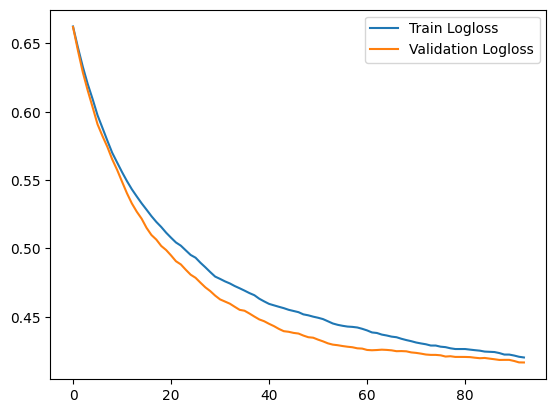

[0]	validation_0-logloss:0.67943
[1]	validation_0-logloss:0.67427
[2]	validation_0-logloss:0.67013
[3]	validation_0-logloss:0.66737
[4]	validation_0-logloss:0.66352
[5]	validation_0-logloss:0.65825
[6]	validation_0-logloss:0.65465
[7]	validation_0-logloss:0.65465
[8]	validation_0-logloss:0.65095
[9]	validation_0-logloss:0.64669
[10]	validation_0-logloss:0.64266
[11]	validation_0-logloss:0.63981
[12]	validation_0-logloss:0.63552
[13]	validation_0-logloss:0.63243
[14]	validation_0-logloss:0.62992
[15]	validation_0-logloss:0.62641
[16]	validation_0-logloss:0.62317
[17]	validation_0-logloss:0.61941
[18]	validation_0-logloss:0.61647
[19]	validation_0-logloss:0.61358
[20]	validation_0-logloss:0.61119
[21]	validation_0-logloss:0.61119
[22]	validation_0-logloss:0.60948
[23]	validation_0-logloss:0.60707
[24]	validation_0-logloss:0.60385
[25]	validation_0-logloss:0.60131
[26]	validation_0-logloss:0.59906
[27]	validation_0-logloss:0.59656
[28]	validation_0-logloss:0.59434
[29]	validation_0-loglos

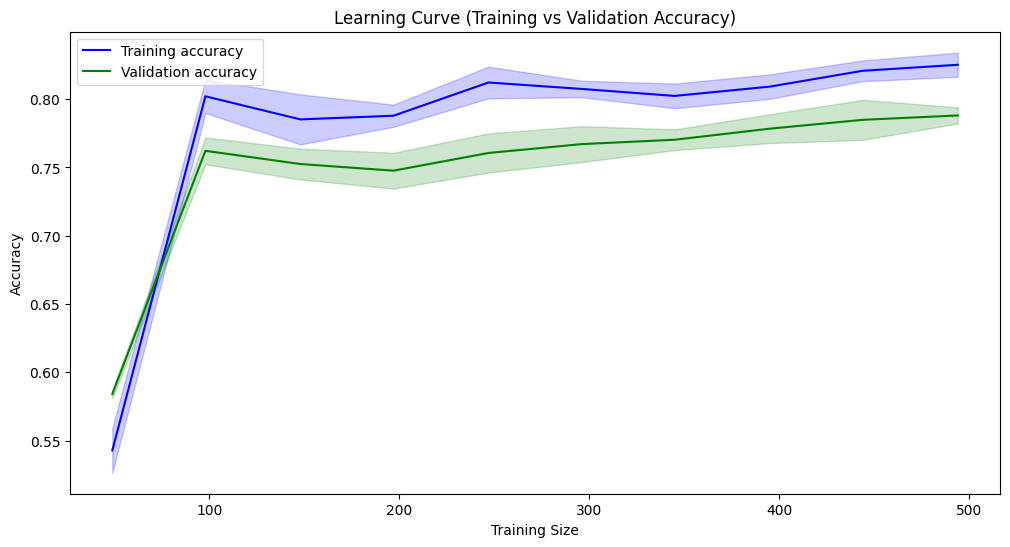

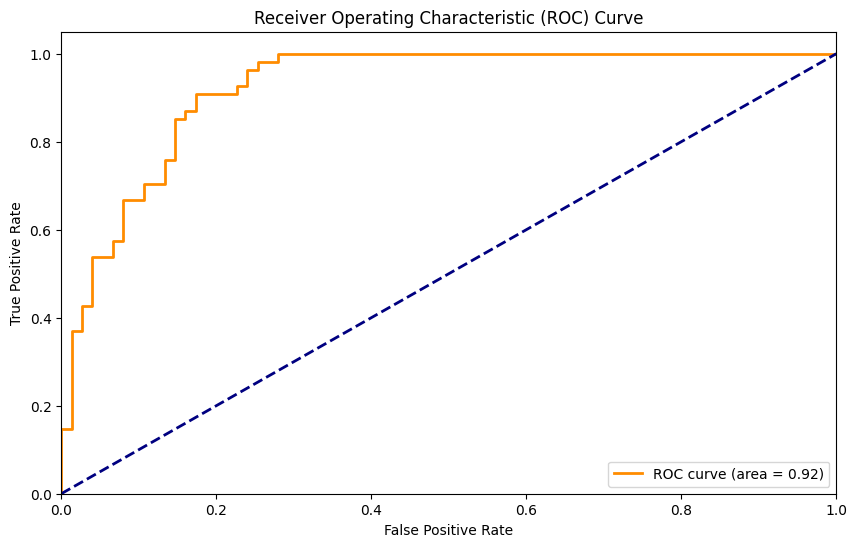

In [14]:

best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


# Get the evaluation results from the training process
results = final_model.evals_result()

# Print the available keys in results to help diagnose the issue
print("Available results keys:", results.keys())

# Check if 'validation_1' exists in the results
if 'validation_1' in results:
    # Plot learning curves for training and validation
    pyplot.plot(results['validation_0']['logloss'], label='Train Logloss')
    pyplot.plot(results['validation_1']['logloss'], label='Validation Logloss')
else:
    print("Validation set logloss not found in the results")

# Show the legend and plot
pyplot.legend()
pyplot.show()

# Learning Curves with Early Stopping
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10),
    fit_params={'eval_set': [(X_valid, y_valid)]}  # Still using validation set for this step
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC-ROC Plot
# Get predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

best_params = {
    'max_depth': 4, 
    'learning_rate': 0.055,  
    'n_estimators': 150,  
    'min_child_weight': 4,  
    'gamma': 0.75,  
    'subsample': 0.65, 
    'colsample_bytree': 0.7,  
    'lambda': 8, 
    'alpha': 4,  
    'early_stopping_rounds': 87,
}
# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train set: 618 samples
Validation set: 110 samples
Test set: 129 samples
Train Accuracy: 0.8446601941747572
Test Accuracy: 0.813953488372093


In [16]:
import shap

In [17]:
import shap

In [18]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_train)


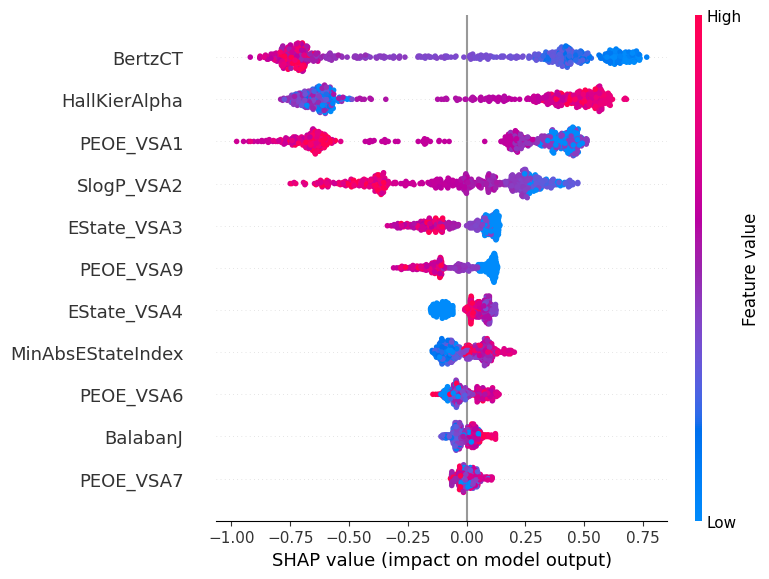

In [19]:
shap.summary_plot(shap_values, X_train)

In [20]:
import joblib

joblib.dump(final_model, 'xgb_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [21]:
XGB_features = ['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'SlogP_VSA2',
 'MinAbsEStateIndex',
 'EState_VSA4',
 'PEOE_VSA6',
 'EState_VSA3',
 'PEOE_VSA7',
 'BalabanJ',
 'PEOE_VSA9']